## Import 

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds



In [3]:
import matplotlib.pyplot as plt
import pandas as pd


## Load Data

In [29]:
data_dir = '../raw_data'

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=32, 
    image_size=(256, 256), 
    shuffle=True, 
    seed=42 
)

Found 55448 files belonging to 39 classes.


In [98]:
train_val_ds = dataset.take(round(len(dataset) * 0.9))  # 90% pour l'entraînement
test_ds = dataset.skip(round(len(dataset) * 0.9))  # 10% pour le test

In [99]:
train_ds = train_val_ds.take(round(len(train_val_ds) * 0.8))  # 80% pour l'entraînement
val_ds = train_val_ds.skip(round(len(train_val_ds) * 0.8))  # 20% pour le test

In [102]:
val_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=312>

In [42]:
index_dict={key:value for key, value in zip(dataset.class_names, range(40))}

In [43]:
index_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Background_without_leaves': 4,
 'Blueberry___healthy': 5,
 'Cherry___Powdery_mildew': 6,
 'Cherry___healthy': 7,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8,
 'Corn___Common_rust': 9,
 'Corn___Northern_Leaf_Blight': 10,
 'Corn___healthy': 11,
 'Grape___Black_rot': 12,
 'Grape___Esca_(Black_Measles)': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Grape___healthy': 15,
 'Orange___Haunglongbing_(Citrus_greening)': 16,
 'Peach___Bacterial_spot': 17,
 'Peach___healthy': 18,
 'Pepper,_bell___Bacterial_spot': 19,
 'Pepper,_bell___healthy': 20,
 'Potato___Early_blight': 21,
 'Potato___Late_blight': 22,
 'Potato___healthy': 23,
 'Raspberry___healthy': 24,
 'Soybean___healthy': 25,
 'Squash___Powdery_mildew': 26,
 'Strawberry___Leaf_scorch': 27,
 'Strawberry___healthy': 28,
 'Tomato___Bacterial_spot': 29,
 'Tomato___Early_blight': 30,
 'Tomato___Late_blight': 31,
 'Tomato__

In [54]:
for image, labels in dataset.take(1): 
    print(image.shape)

(32, 256, 256, 3)


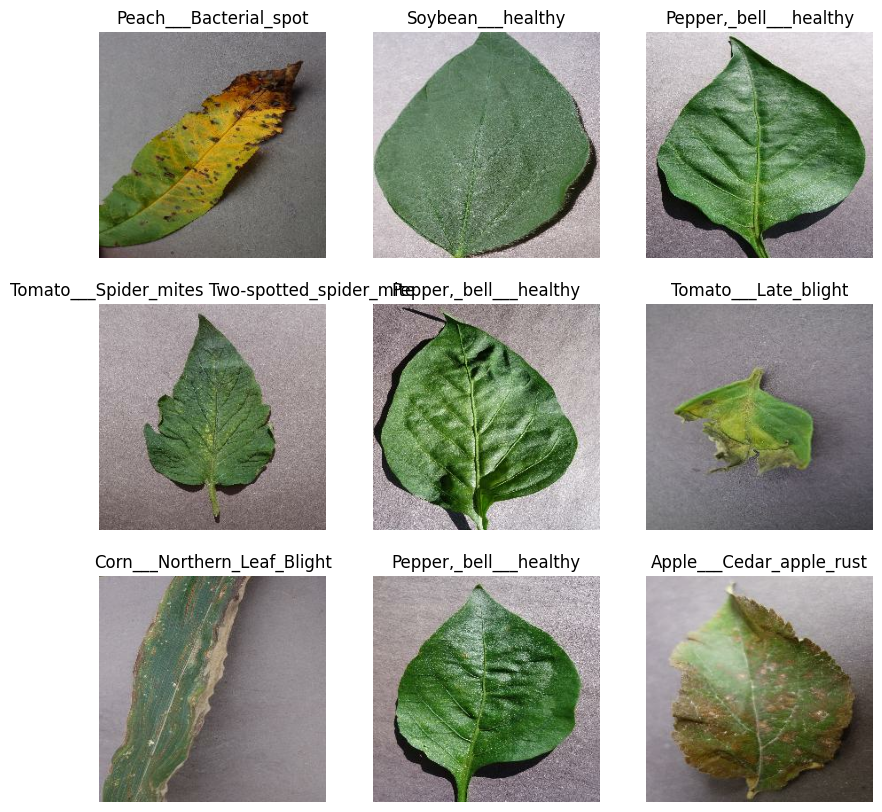

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint16"))
        plt.title(dataset.class_names[labels[i]])
        plt.axis("off")

## Model

In [33]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(256,256,3)),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.CenterCrop(height=224, width=224), 
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(64, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(246, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(39, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 center_crop_1 (CenterCrop)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 221, 221, 64)      3136      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                  

In [37]:
initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  
    decay_rate=0.9  
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [38]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping


es = EarlyStopping(patience=3, restore_best_weights=True)


In [40]:
model.fit(train_ds,
          callbacks=es,
          validation_data=val_ds,
          epochs=2)

Epoch 1/2


/home/chinzi/.pyenv/versions/3.10.6/envs/LeafScan/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


   5/1404 [..............................] - ETA: 38:25 - loss: 11.6890 - accuracy: 0.0250

KeyboardInterrupt: 

In [31]:
model.evaluate(test_ds)

170/170 [==============================] - 4s 24ms/step - loss: 0.6191 - accuracy: 0.8109


[0.6190786361694336, 0.810865581035614]

## Transfer Learning 

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense

# Charger le modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Ajouter une couche Dense supplémentaire
x = base_model.output
x = Dense(256, activation='relu')(x)
predictions = Dense(38, activation='softmax')(x)

# Créer le nouveau modèle en spécifiant les couches d'entrée et de sortie
model = Model(inputs=base_model.input, outputs=predictions)

# Visualiser l'architecture du nouveau modèle
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5


InvalidArgumentError: ignored